# Voice quality analysis - Esling et al. Chapter 2 illustrations

This notebook uses audio which was extracted from the example videos provided with Esling et al. 2019 "Voice Quality".

In [1]:
import os                            # operating sytem functions
from pathlib import Path             # cross-platform file path references
from fileorganize import dir_to_df   # read a corpus into a dataframe
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import phonlab as phon
from IPython.display import Audio
import seaborn as sns
from scipy.stats import median_abs_deviation as mad

sns.axes_style("darkgrid")  # set some themes for seaborn plots
sns.set_theme()

print(f"phonab version {phon.__version__}")

phonab version 0.0.38


# set up some variables and get a list of textgrid files

In [2]:
folder = os.getcwd()
print(folder)  ## just so you know where we will be looking for the corpus

path_to_corpus = Path('.')
path_to_results = Path('./acoustic_results')  # this notebook will create this directory if it doesn't already exist

corpus_list = dir_to_df(path_to_corpus,
               fnpat = r'Video2_\d\d(.?)-(?P<type>.*)\.TextGrid',
               addcols = ["dirname", "barename"])
corpus_list.head()

/Users/kjohnson/My Drive (keithjohnson@berkeley.edu)/Esling_etal_samples


,dirname,relpath,fname,barename,type
0,.,.,Video2_03a-breath-aspiration.TextGrid,Video2_03a-breath-aspiration,breath-aspiration
1,.,.,Video2_03b-breath-voiceless_fricative.TextGrid,Video2_03b-breath-voiceless_fricative,breath-voiceless_fricative
2,.,.,Video2_03x-laughter-breath.TextGrid,Video2_03x-laughter-breath,laughter-breath
3,.,.,Video2_04-modal_voice.TextGrid,Video2_04-modal_voice,modal_voice
4,.,.,Video2_04x-laughter-modal_voice.TextGrid,Video2_04x-laughter-modal_voice,laughter-modal_voice


##  a couple of helper functions that may end up in phonlab

In [3]:

def tslice(match_ts, time_ts, time_df):
    '''
    Return dataframe of .iloc indexes into match_ts that are within
    time intervals defined by time_ts/time_df
    '''
    if time_df is not None:
        t1 = time_df[time_ts[0]].values
        t2 = time_df[time_ts[1]].values
    else:
        t1 = np.array(time_ts[0])
        t2 = np.array(time_ts[1])
    match = match_ts.values if isinstance(match_ts, pd.Series) else np.array(match_ts)
    slice_df = pd.DataFrame(
        np.argwhere(
            (match >= np.expand_dims(t1, axis=1)) & \
            (match <= np.expand_dims(t2, axis=1))
        ),
        columns=['group', 'iloc']
    )
    if time_df is not None:
        slice_df['group'] = time_df.iloc[slice_df['group']].index
    return slice_df

def aggregate_measures(meas_df,meas_ts = 'sec', time_df=None, time_ts=['t1','t2'], func = ['mean', 'std'], overwrite=False):

    try:
        assert(np.all(np.diff(meas_df[meas_ts]) > 0))
    except AssertionError:
        msg = 'The time column of `meas_df` must be increasing.'
        raise ValueError(msg) from None
        
    meas_cols = [c for c in meas_df.columns if c != meas_ts]
    try:
        if not overwrite:
            overlaps = set(time_df.columns) & set(meas_cols)
            assert(len(overlaps) == 0)
    except AssertionError:
        msg = f'Found overlap of columns in `time_df` and `meas_df`. To overwrite the measurements in the {overlaps} column(s) in `interp_df` set the parameter `overwrite=True`. If you wish to keep the existing measurements and add new columns from `meas_df` you can `rename` the column(s) in the input dataframes so that they do not match.'
        raise ValueError(msg) from None

    slice_df = tslice(match_ts=meas_df[meas_ts], time_ts=time_ts, time_df=time_df)
    aggmeas = meas_df.iloc[slice_df['iloc']] \
                .set_index(time_df.loc[slice_df['group']].index) \
                .groupby(level=0)[meas_cols].agg(func)
    aggmeas.columns = ['_'.join(col).strip() for col in aggmeas.columns.values]  # Flatten MultiIndex

    return time_df.join(aggmeas)


# a function to do VQ analysis on a single file

    * reads the textgrid and gives median and stdev of several measures in each vowel

In [107]:
def do_vq_analysis(row):
    ''' Compute voice quality measures for a single TextGrid file in a dir_to_df() dataframe

        Assumptions:  * = could easily be passed into this function
            * path_to_corpus is defined globally
            * The audio of interest is in channel 0 of the file
            * we are only interested in a specific list of vowels
            * there is a tier in the TextGrid called 'phones' that has our vowels of interest
            * I gave an initial f0_range
            - there is a wav file that has the same barename as the TextGrid file 
            - the wav file is in the same directory as the TextGrid file
            - I hardwired which analyses to do
            - I hardwired how to compute the F0 range from the F0 median
            - I hardwired that the sampling rate for analysis will be 16kHz
            - I hardwired a fix for a stupid file naming problem that was found in these particular files    
    '''
    newbarename = row.barename.replace("Video2_", "Video2.", 1)  # praat changed the filenames!
    wavfile = path_to_corpus / row.relpath / f"{newbarename}.wav"  # first file on the list
    print(wavfile)
    textgridpath = path_to_corpus / row.relpath / row.fname

    # ---- read text grid as a dataframe, add a variable to the data, and subset to just the vowels.
    [df] = phon.tg_to_df(textgridpath) 
    df['vq_type'] = row.type  # filename identifies voice quality type being demonstrated
    vowels = ['ə', 'ɛ', 'a','ɛ̥']
    vowelsdf = df.query(f'phones in {vowels}').copy()  # make a dataframe that just has vowels

    # --- read the left channel of the audio file, downsample to 16kHz, and calculate the LPC residual
    x,fs = phon.loadsig(wavfile, chansel=[0])
    x,fs = phon.prep_audio(x, fs, target_fs=16000, pre = 0, quiet=True)  # resample, scale, set polarity

    # --- Get an initial median F0 value for the file, and set the F0 range for this file
    f0_range=[60,275]

    f0ac = phon.get_f0(x,fs,f0_range=f0_range)  # first pass F0 measurment with autocorrelation
    f0med = np.nanmedian(f0ac.f0)
    f0_range = [f0_range[0], int(f0med + 0.75*f0med)]       # adjust the top end of the range
    print(f"AC: f0 median = {f0med:0.1f}, f0_range ={f0_range}")

    # --- call lots of analysis routines to calculate voice quality data   
    hnr_df = phon.HNR(x,fs, f0_range=f0_range)
    f0med = np.nanmedian(hnr_df.f0)
    f0_range = [f0_range[0], int(f0med + 0.6*f0med)]
    print(f"HNR: f0 median = {f0med:0.1f}, f0_range ={f0_range}")
    f0shr = phon.get_f0_shs(x,fs,f0_range=f0_range)
    f0ac = phon.get_f0(x,fs,f0_range=f0_range)
    f0cpp = phon.CPP(x,fs,f0_range=f0_range)
    f0acd = phon.get_f0_acd(x,fs,f0_range=f0_range)
    f0srh = phon.get_f0_srh(x,fs,f0_range=f0_range)
    gci_df, mbs,resid = phon.gci_sedreams(x,fs,f0med,cthresh=0.0)
    h2h1_df = phon.h2h1(resid,fs,hnr_df) 

    # --- aggregate the data over each vowel and append the aggregated data to the textgrid info
    vowelsdf = aggregate_measures(meas_df=f0ac[['sec','HNR']], time_df=vowelsdf, func=['median', mad])
    vowelsdf = aggregate_measures(meas_df=hnr_df[['sec','f0', 'hnr_500','hnr_1500']], time_df=vowelsdf, func=['median',mad])
    vowelsdf = aggregate_measures(meas_df=f0acd[['sec','h1h2']], time_df=vowelsdf, func=['median',mad])
    vowelsdf = aggregate_measures(meas_df=h2h1_df[['sec','h2h1']], time_df=vowelsdf, func=['median',mad])
    vowelsdf = aggregate_measures(meas_df=f0shr[['sec','shr']], time_df=vowelsdf, func=['median',mad])
    vowelsdf = aggregate_measures(meas_df=gci_df[['sec','jitter','soe']], time_df=vowelsdf, func=['median',mad])
    vowelsdf = aggregate_measures(meas_df=f0cpp[['sec','cpp']], time_df=vowelsdf, func=['median',mad])

    vowelsdf.columns = [c.replace("median_abs_deviation","mad") for c in vowelsdf.columns]  
    
    return vowelsdf

test_df = do_vq_analysis(corpus_list.loc[1])
test_df.head()

Video2.03b-breath-voiceless_fricative.wav
AC: f0 median = 134.5, f0_range =[60, 235]
HNR: f0 median = 152.4, f0_range =[60, 243]


,t1,t2,phones,vq_type,HNR_median,HNR_mad,f0_median,f0_mad,hnr_500_median,hnr_500_mad,...,h2h1_median,h2h1_mad,shr_median,shr_mad,jitter_median,jitter_mad,soe_median,soe_mad,cpp_median,cpp_mad
1,0.668490,0.869855,ə,breath-voiceless_fricative,15.191164,5.765941,134.453782,2.222377,19.264621,4.597728,...,-45.222673,2.552351,0.548179,NaN,0.008333,0.008333,0.484406,0.143249,11.846417,3.973017
3,1.156767,1.512117,ə,breath-voiceless_fricative,9.990968,2.747658,122.137405,23.371972,18.265900,4.768251,...,-32.060036,19.150167,0.384477,NaN,0.009723,0.005177,0.422539,0.060375,11.070851,2.047776


# do the VQ analysis on the whole corpus

In [108]:
dflist = []
s = ""
for row in corpus_list.itertuples():
    if s != row.type:  # print a new message when we get on to files from a new subject
        s = row.type
        print(s)
    dflist.append(do_vq_analysis(row))

all_data = pd.concat(dflist,ignore_index=True)   # all data contains data from all of the files in the corpus
all_data.shape

breath-aspiration
Video2.03a-breath-aspiration.wav
AC: f0 median = 156.9, f0_range =[60, 274]
HNR: f0 median = 158.4, f0_range =[60, 253]
breath-voiceless_fricative
Video2.03b-breath-voiceless_fricative.wav
AC: f0 median = 134.5, f0_range =[60, 235]
HNR: f0 median = 152.4, f0_range =[60, 243]
laughter-breath
Video2.03x-laughter-breath.wav
AC: f0 median = 60.6, f0_range =[60, 106]
HNR: f0 median = 80.8, f0_range =[60, 129]
modal_voice
Video2.04-modal_voice.wav
AC: f0 median = 114.3, f0_range =[60, 200]
HNR: f0 median = 146.8, f0_range =[60, 234]
laughter-modal_voice
Video2.04x-laughter-modal_voice.wav
AC: f0 median = 123.1, f0_range =[60, 215]
HNR: f0 median = 146.8, f0_range =[60, 234]
glottal_stop-onset
Video2.06-glottal_stop-onset.wav
AC: f0 median = 149.5, f0_range =[60, 261]
HNR: f0 median = 150.9, f0_range =[60, 241]
glottal_stop-coda
Video2.07-glottal_stop-coda.wav
AC: f0 median = 125.0, f0_range =[60, 218]
HNR: f0 median = 129.0, f0_range =[60, 206]
epiglottal_stop
Video2.08-epi

(60, 24)

In [109]:
# recode filenames to a smaller number of voice quality types
di = {'breath-aspiration': 'modal', 'breath-voiceless_fricative': 'modal','modal_voice': 'modal', 'laughter-modal_voice':'modal',
     'glottal_stop-onset': 'modal', 'glottal_stop-coda': 'modal', 'laughter-laryngeal_constriction-high':'laryngeal_constriction',
     'harsh_voice-mid': 'harsh_voice', 'aryepiglottic_trill-low': 'aryepiglottic_trill', 'laughter-aryepiglottic_trill-low': 'aryepiglottic_trill',
     'laryngeal_constriction-high':'laryngeal_constriction'}
all_data['vq'] = all_data['vq_type'].replace(di)


In [110]:
all_data.head()

,t1,t2,phones,vq_type,HNR_median,HNR_mad,f0_median,f0_mad,hnr_500_median,hnr_500_mad,...,h2h1_mad,shr_median,shr_mad,jitter_median,jitter_mad,soe_median,soe_mad,cpp_median,cpp_mad,vq
0,0.545431,1.015595,ə,breath-aspiration,22.654041,3.408873,150.943396,2.116402,27.522517,2.372324,...,1.659580,NaN,NaN,0.004878,0.004878,0.168440,0.056579,16.713561,1.147120,modal
1,0.668490,0.869855,ə,breath-voiceless_fricative,15.191164,5.765941,134.453782,2.222377,19.264621,4.597728,...,2.552351,0.548179,NaN,0.008333,0.008333,0.484406,0.143249,11.846417,3.973017,modal
2,1.156767,1.512117,ə,breath-voiceless_fricative,9.990968,2.747658,122.137405,23.371972,18.265900,4.768251,...,19.150167,0.384477,NaN,0.009723,0.005177,0.422539,0.060375,11.070851,2.047776,modal
3,0.654481,1.603639,ə,modal_voice,23.984474,2.501824,146.788991,1.334445,31.431609,3.010427,...,0.606995,0.873821,NaN,0.035088,0.030522,0.435046,0.174225,18.241951,0.825959,modal
4,0.129483,0.229574,ə,laughter-modal_voice,7.338409,2.025304,200.000000,10.526316,27.480214,4.840671,...,2.105741,NaN,NaN,0.019608,0.010392,0.265519,0.114923,10.058240,2.748779,modal


# visualize an acoustic measure

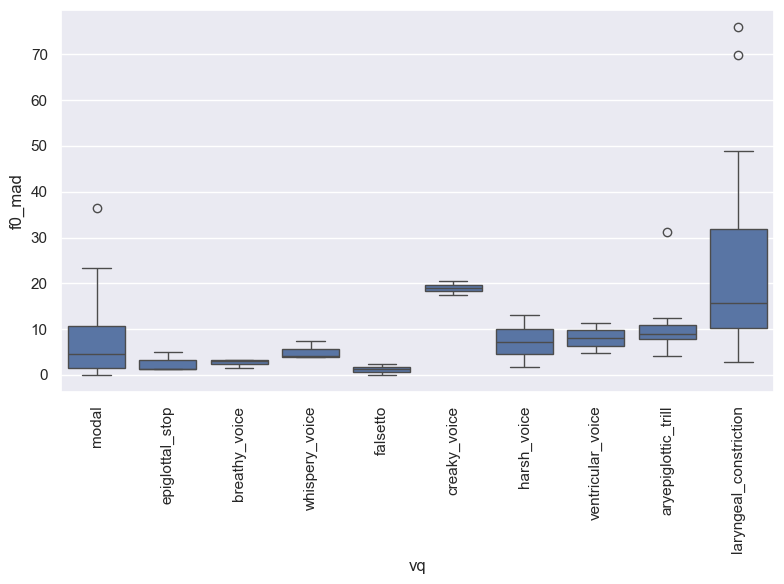

In [111]:
fig, ax = plt.subplots(1, 1, figsize=(8, 6))
#nonan_all_data = all_data[~np.isnan(all_data)]

sns.boxplot(all_data,x="vq",y="f0_mad",ax=ax)
#sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
ax.tick_params(axis='x', rotation=90)
plt.tight_layout()

# Use PCA to reduce dimensionality

In [112]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

# get column names that end in 'median' or 'std'
measures = [c for c in all_data.columns if "median" in c  or "mad" in c]  

# a couple of lines here to sort the measures into the order I want - medians then std
revmeas = list(reversed(sorted([measures[i][::-1] for i in range(len(measures))])))
s_meas = [revmeas[i][::-1] for i in range(len(revmeas))]

X = all_data.fillna(0)[s_meas]
X_norm = scaler.fit_transform(X)  # standardize the data (for multi-talker data this will need to be by talker)

pca = PCA(n_components=7).fit(X_norm)
X_new = pca.transform(X_norm)

pc_scores = pd.DataFrame(X_new,columns=["PC1","PC2","PC3","PC4","PC5","PC6","PC7"])
data_with_PCs = all_data.join(pc_scores)  # add the PCs into the original dataframe

print(pca.explained_variance_ratio_)

[0.25411294 0.22635305 0.15214786 0.09355596 0.06235375 0.05569073
 0.03151114]


### Visualize the relationship between the PCA components and the data
    * by plotting the PCA compenents
    * by plotting the correlations between PC scores and acoustic measures

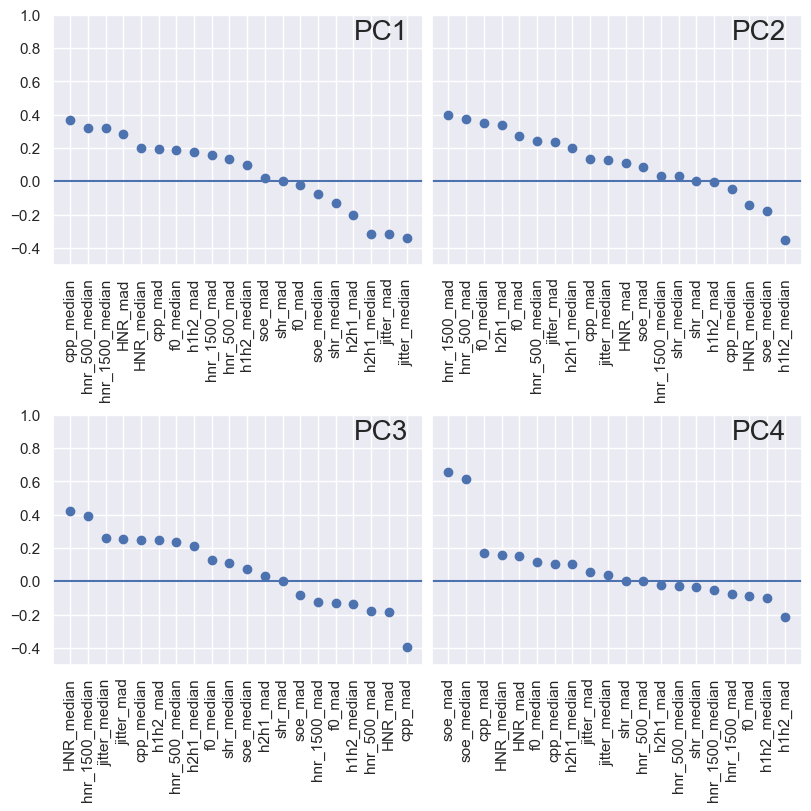

In [113]:
fig, axs = plt.subplots(2,2,sharex=False,sharey=True,
                        figsize=(8,8),layout='constrained')

label_x = len(s_meas)-4
sorted_meas = [val for _, val in sorted(zip(pca.components_[0], s_meas),reverse=True)]
axs[0,0].scatter(sorted_meas,sorted(pca.components_[0],reverse=True))
axs[0,0].tick_params(axis='x', rotation=90)
axs[0,0].set_ylim(-0.5,1)
axs[0,0].text(label_x,0.85,"PC1",size=20)
axs[0,0].axhline(0)

sorted_meas = [val for _, val in sorted(zip(pca.components_[1], s_meas),reverse=True)]
axs[0,1].scatter(sorted_meas,sorted(pca.components_[1],reverse=True))
axs[0,1].tick_params(axis='x', rotation=90)
axs[0,1].text(label_x,0.85,"PC2",size=20)
axs[0,1].axhline(0)

sorted_meas = [val for _, val in sorted(zip(pca.components_[2], s_meas),reverse=True)]
axs[1,0].scatter(sorted_meas,sorted(pca.components_[2],reverse=True))
axs[1,0].tick_params(axis='x', rotation=90)
axs[1,0].text(label_x,0.85,"PC3",size=20)
axs[1,0].axhline(0)

sorted_meas = [val for _, val in sorted(zip(pca.components_[3], s_meas),reverse=True)]
axs[1,1].scatter(sorted_meas,sorted(pca.components_[3],reverse=True))
axs[1,1].tick_params(axis='x', rotation=90)
axs[1,1].text(label_x,0.85,"PC4",size=20)
axs[1,1].axhline(0)

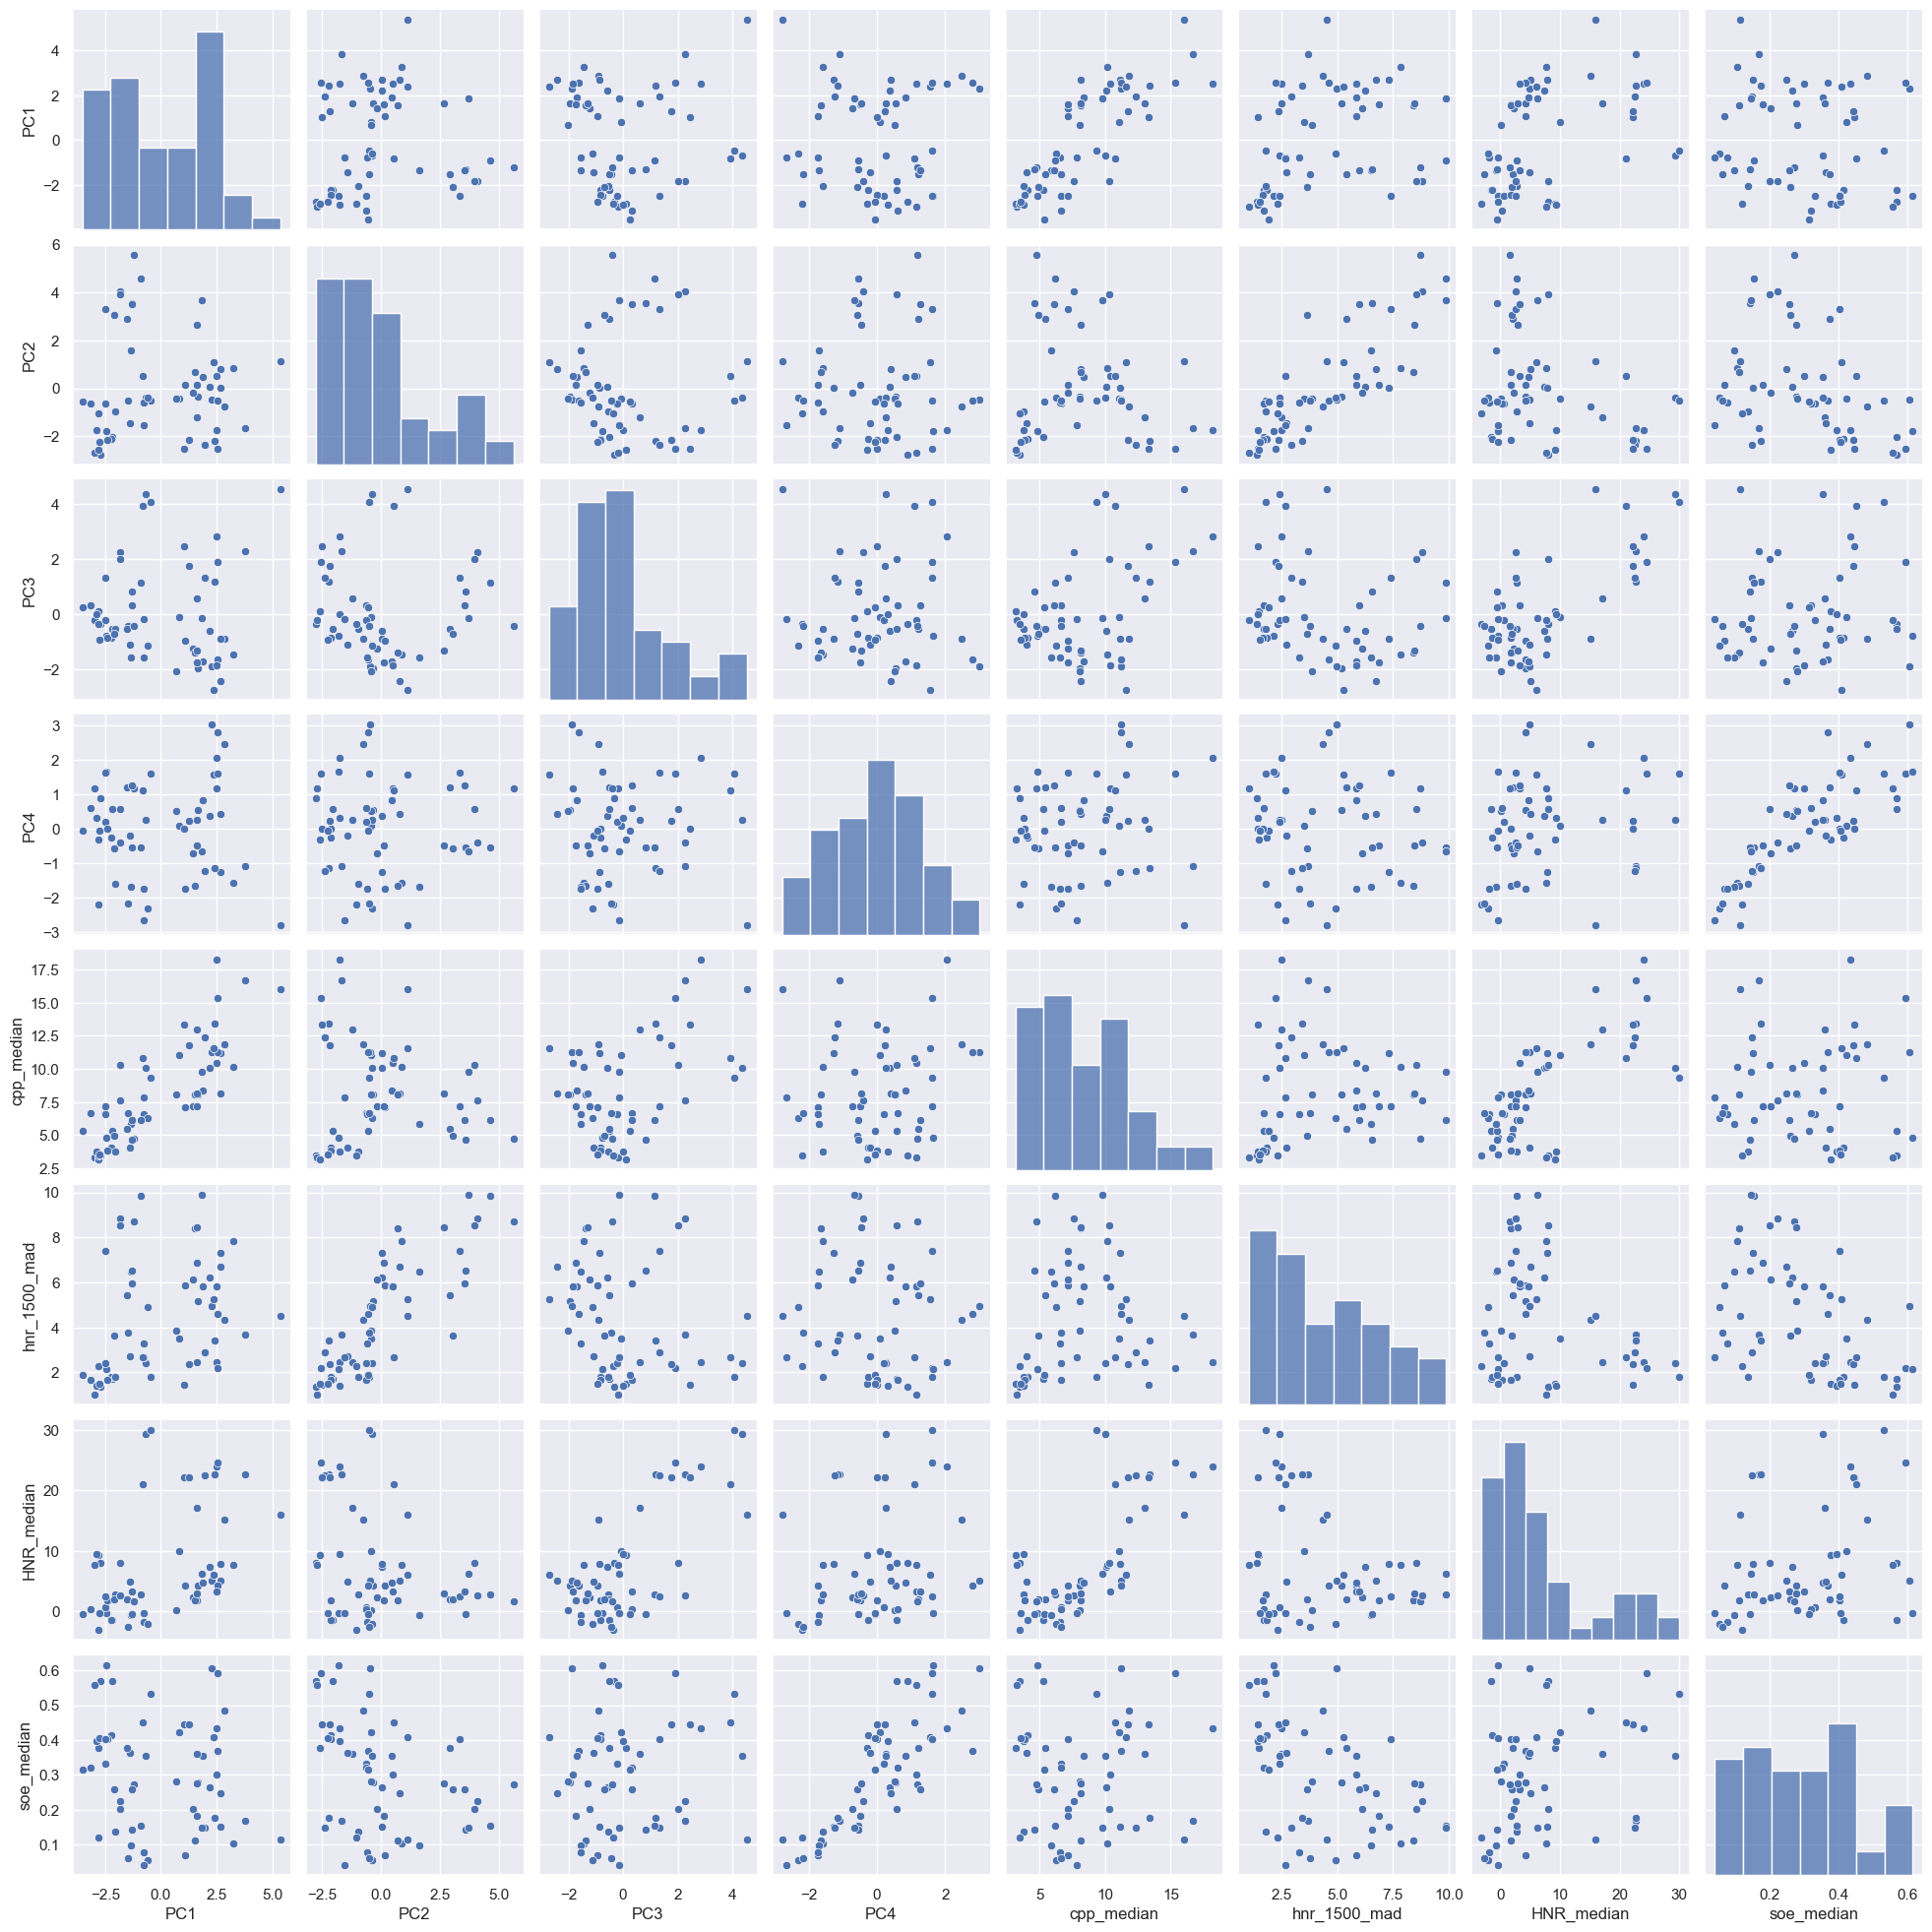

In [114]:
ax = sns.pairplot(data_with_PCs[['PC1','PC2','PC3','PC4','cpp_median','hnr_1500_mad','HNR_median','soe_median']])

# Visualize the 'voice space'

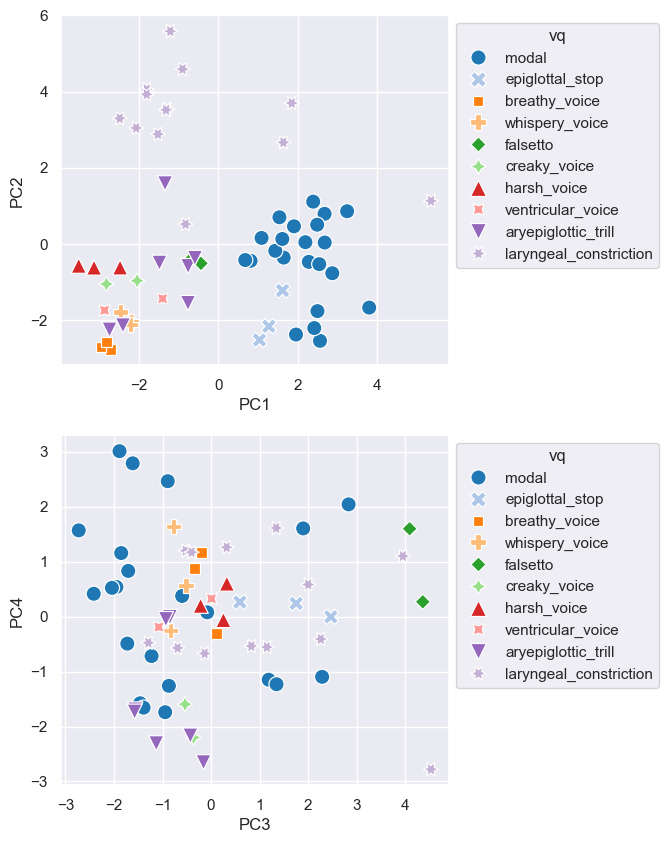

In [115]:
fig2, [ax1,ax2] = plt.subplots(2, 1,figsize=(5,10))

sns.scatterplot(data=data_with_PCs, x="PC1", y="PC2", hue="vq", palette = "tab20", style='vq',
                         size='vq',sizes=(120,120),ax = ax1)
sns.scatterplot(data=data_with_PCs, x="PC3", y="PC4", hue="vq", palette = "tab20", style='vq',
                         size='vq',sizes=(120,120),ax = ax2)
sns.move_legend(ax1, "upper left", bbox_to_anchor=(1, 1))
sns.move_legend(ax2, "upper left", bbox_to_anchor=(1, 1))

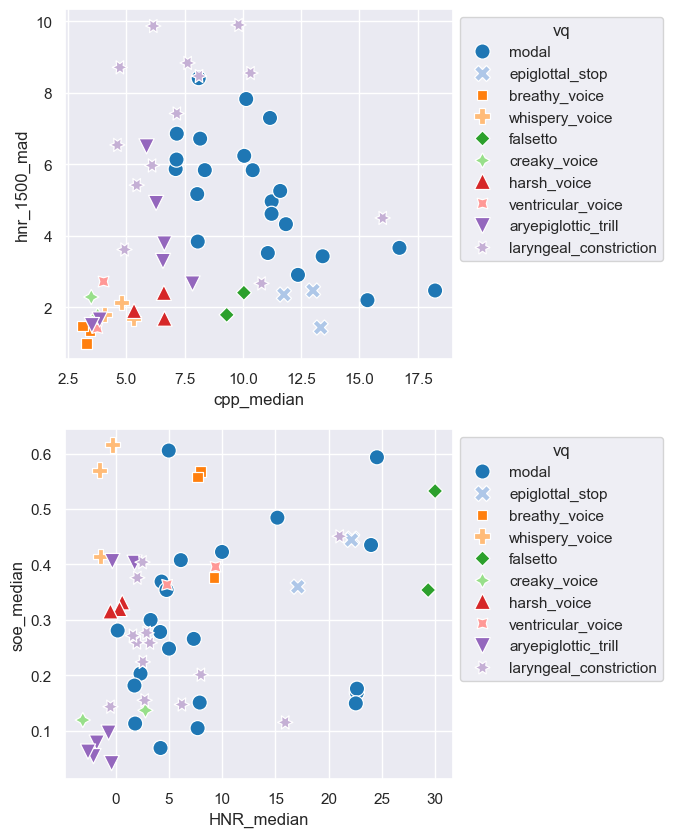

In [116]:
fig2, [ax1,ax2] = plt.subplots(2, 1,figsize=(5,10))

sns.scatterplot(data=data_with_PCs, x="cpp_median", y="hnr_1500_mad", hue="vq", palette = "tab20", style='vq',
                         size='vq',sizes=(120,120),ax = ax1)
sns.scatterplot(data=data_with_PCs, x="HNR_median", y="soe_median", hue="vq", palette = "tab20", style='vq',
                         size='vq',sizes=(120,120),ax = ax2)
sns.move_legend(ax1, "upper left", bbox_to_anchor=(1, 1))
sns.move_legend(ax2, "upper left", bbox_to_anchor=(1, 1))